**PubmedBERT model to identify and map out feature entities in clinical notes**

1. import and setup

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.6 MB/s eta 0:00:00


In [2]:
from ast import literal_eval
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer

In [3]:
#display options
pd.set_option('display.max_colwidth', None)

## NBME - Score Clinical Patient Notes : analysis

In [4]:
from google.colab import files
import io
uploaded_notes = files.upload()
patient_notes = pd.read_csv(io.BytesIO(uploaded_notes['patient_notes.csv']))   

Saving patient_notes.csv to patient_notes.csv


In [5]:
uploaded_features = files.upload()
features = pd.read_csv(io.BytesIO(uploaded_features['features.csv'])) 


Saving features.csv to features.csv


In [6]:
uploaded_train = files.upload()
data = pd.read_csv(io.BytesIO(uploaded_train['train.csv'])) 

Saving train.csv to train.csv


### preprocess 

- clean text& prepare dataset 
- tokenize the data 

In [7]:
def process_feature_text(text):
    return text.replace("-OR-", ";-").replace("-", " ")


def prepare_datasets(features,notes,df):
    df["annotation_list"] = [literal_eval(x) for x in df["annotation"]]
    df["location_list"] = [literal_eval(x) for x in df["location"]]

    merged = df.merge(notes, how="left")
    merged = merged.merge(features, how="left")

    merged["feature_text"] = [process_feature_text(x) for x in
                              merged["feature_text"]]
    merged["feature_text"] = merged["feature_text"].apply(lambda x: x.lower())
    merged["pn_history"] = merged["pn_history"].apply(lambda x: x.lower())

    return merged

2. Tokenizer

In [8]:
def loc_list_to_ints(loc_list):
  # takes a list of location strings as input and converts it to a list of tuples of integers 
  # representing the start and end positions of each location in the original input text
    output = []
    for loc_str in loc_list:
        loc_strs = loc_str.split(";")
        for loc in loc_strs:
            start, end = loc.split()
            output.append((int(start), int(end)))
    return output

In [9]:
def tokenize_and_add_labels(tokenizer, data, config):
    out = tokenizer(
        data["feature_text"],
        data["pn_history"],
        truncation=config['truncation'],
        max_length=config['max_length'],
        padding=config['padding'],
        return_offsets_mapping=config['return_offsets_mapping']
    )
    #intialize label
    labels = [0.0] * len(out["input_ids"])
    out["location_int"] = loc_list_to_ints(data["location_list"])
    out["sequence_ids"] = out.sequence_ids()

    for idx, (seq_id, offsets) in enumerate(zip(out["sequence_ids"],
                                                out["offset_mapping"])):
        if not seq_id or seq_id == 0:
            labels[idx] = -1
            continue

        token_start, token_end = offsets
        for feature_start, feature_end in out["location_int"]:
            if token_start >= feature_start and token_end <= feature_end:
                labels[idx] = 1.0
                break

    out["labels"] = labels

    return out

This function loops through each token in the out dictionary, using the token's sequence_id and offset_mapping to determine whether it corresponds to a feature in the input text. If it does, the corresponding label in the labels list is set to 1.0. If not, the label is set to -1


The sequence_id of each token is used to skip over tokens that are special tokens or padding tokens that were added by the tokenizer. If a token has a sequence_id of 0 or None, it is skipped and its corresponding label is set to -1.

3. create dataset

In [10]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, config):
        self.data = data
        self.tokenizer = tokenizer
        self.config = config

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data.iloc[idx]
        tokens = tokenize_and_add_labels(self.tokenizer, data, self.config)

        input_ids = np.array(tokens["input_ids"])
        attention_mask = np.array(tokens["attention_mask"])
        token_type_ids = np.array(tokens["token_type_ids"])

        labels = np.array(tokens["labels"])
        offset_mapping = np.array(tokens['offset_mapping'])
        sequence_ids = np.array(tokens['sequence_ids']).astype("float16")
        
        return input_ids, attention_mask, token_type_ids, labels, offset_mapping, sequence_ids

In [11]:
hyperparameters = {
    "max_length": 416,
    "padding": "max_length",
    "return_offsets_mapping": True,
    "truncation": "only_second",
    "model_name": ("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"),
    "dropout": 0.2,
    "lr": 1e-5,
    "test_size": 0.2,
    "valid_size":0.2,
    "seed": 1268,
    "batch_size": 8
}

In [12]:
train_df = prepare_datasets(features=features,notes=patient_notes,df=data)

X_train, X_test = train_test_split(train_df,
                                   test_size=hyperparameters['test_size'],
                                   random_state=hyperparameters['seed'])
X_train, X_valid = train_test_split(X_train,
                                   test_size=hyperparameters['valid_size'],
                                   random_state=hyperparameters['seed'])

print("Train size", len(X_train))
print("Test Size", len(X_test))
print("Valid Size", len(X_valid))

Train size 9152
Test Size 2860
Valid Size 2288


In [13]:
tokenizer = AutoTokenizer.from_pretrained(hyperparameters['model_name'])

training_data = CustomDataset(X_train,
                              tokenizer,
                              hyperparameters)

train_dataloader = DataLoader(training_data,
                              batch_size=hyperparameters['batch_size'],
                              shuffle=True)

valid_data = CustomDataset(X_valid, tokenizer, hyperparameters)

valid_dataloader = DataLoader(valid_data,
                             batch_size=hyperparameters['batch_size'],
                             shuffle=False)

test_data = CustomDataset(X_test, tokenizer, hyperparameters)

test_dataloader = DataLoader(test_data,
                             batch_size=hyperparameters['batch_size'],
                             shuffle=False)

4. Model utils

In [14]:
def get_location_predictions(preds, offset_mapping, sequence_ids):
    all_predictions = []
    for pred, offsets, seq_ids in zip(preds, offset_mapping, sequence_ids):
        #apply sigmoid
        pred = 1 / (1 + np.exp(-pred))
        start_idx = None
        end_idx = None
        current_preds = []
        for pred, offset, seq_id in zip(pred, offsets, seq_ids):
            if seq_id is None or seq_id == 0:
                continue
            # when the prediction value drops below 0.5, the start and end positions are added to the current_preds list.
            if pred > 0.5:
                if start_idx is None:
                    start_idx = offset[0]
                end_idx = offset[1]
            elif start_idx is not None:
              current_preds.append((start_idx, end_idx))
              start_idx = None

            all_predictions.append(current_preds)
            
    return all_predictions



def calculate_char_cv(predictions, offset_mapping, sequence_ids, labels):
    all_labels = []
    all_preds = []
    for preds, offsets, seq_ids, labels in zip(predictions, offset_mapping,
                                               sequence_ids, labels):

        num_chars = max(list(chain(*offsets)))
        char_labels = np.zeros(num_chars)

        for o, s_id, label in zip(offsets, seq_ids, labels):
            if s_id is None or s_id == 0:
                continue
            if int(label) == 1:
                char_labels[o[0]:o[1]] = 1

        char_preds = np.zeros(num_chars)

        for start_idx, end_idx in preds:
            char_preds[start_idx:end_idx] = 1
            
        all_labels.extend(char_labels)
        all_preds.extend(char_preds)

    results = precision_recall_fscore_support(all_labels,
                                              all_preds,
                                              average="binary",
                                              labels=np.unique(all_preds))
    accuracy = accuracy_score(all_labels, all_preds)
    

    return {
        "Accuracy": accuracy,
        "precision": results[0],
        "recall": results[1],
        "f1": results[2]
    }

In [15]:
import torch.nn.functional as F


class CustomModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = AutoModel.from_pretrained(config['model_name']) 
        self.dropout = nn.Dropout(p=config['dropout'])
        self.config = config
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 1)
        

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        logits = F.relu(self.fc1(outputs[0]))
        logits = self.fc2(self.dropout(logits)).squeeze(-1)
        return logits

4. Fit & train

In [16]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = CustomModel(hyperparameters).to(DEVICE)

criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
optimizer = optim.AdamW(model.parameters(), lr=hyperparameters['lr'])

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
def train_model(model, dataloader, optimizer, criterion):
        model.train()
        train_loss = []

        for batch in tqdm(dataloader):
            optimizer.zero_grad()
            input_ids = batch[0].to(DEVICE)
            attention_mask = batch[1].to(DEVICE)
            token_type_ids = batch[2].to(DEVICE)
            labels = batch[3].to(DEVICE)

            logits = model(input_ids,
                           attention_mask,
                           token_type_ids)
            loss = criterion(logits, labels)
            # since, we have
            loss = torch.masked_select(loss, labels > -1.0).mean()
            train_loss.append(loss.item() * input_ids.size(0))
            loss.backward()
            # clip the the gradients to 1.0.
            #It helps in preventing the exploding gradient problem
            # it's also improve f1 accuracy slightly
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        return sum(train_loss)/len(train_loss)


In [18]:
def eval_model(model, dataloader, criterion):
        model.eval()
        valid_loss = []
        preds = []
        offsets = []
        seq_ids = []
        valid_labels = []

        for batch in tqdm(dataloader):
            input_ids = batch[0].to(DEVICE)
            attention_mask = batch[1].to(DEVICE)
            token_type_ids = batch[2].to(DEVICE)
            labels = batch[3].to(DEVICE)
            offset_mapping = batch[4]
            sequence_ids = batch[5]

            logits = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(logits, labels)
            loss = torch.masked_select(loss, labels > -1.0).mean()
            valid_loss.append(loss.item() * input_ids.size(0))

            preds.append(logits.detach().cpu().numpy())
            offsets.append(offset_mapping.numpy())
            seq_ids.append(sequence_ids.numpy())
            valid_labels.append(labels.detach().cpu().numpy())

        preds = np.concatenate(preds, axis=0)
        offsets = np.concatenate(offsets, axis=0)
        seq_ids = np.concatenate(seq_ids, axis=0)
        valid_labels = np.concatenate(valid_labels, axis=0)
        location_preds = get_location_predictions(preds,
                                                  offsets,
                                                  seq_ids)
        score = calculate_char_cv(location_preds,
                                  offsets,
                                  seq_ids,
                                  valid_labels)

        return sum(valid_loss)/len(valid_loss), score

In [19]:
import time

train_loss_data, valid_loss_data = [], []
score_data_list = []
valid_loss_min = np.Inf
since = time.time()
epochs = 10

In [20]:
best_loss = np.inf

for i in range(epochs):
    print("Epoch: {}/{}".format(i + 1, epochs))
    # first train model
    train_loss = train_model(model, train_dataloader, optimizer, criterion)
    train_loss_data.append(train_loss)
    print(f"Train loss: {train_loss}")
    # evaluate model
    valid_loss, score = eval_model(model, valid_dataloader, criterion)
    valid_loss_data.append(valid_loss)
    score_data_list.append(score)
    print(f"Valid loss: {valid_loss}")
    print(f"Valid score: {score}")
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "nbme_pubmed_bert.pth")

    
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/10


  0%|          | 0/1144 [00:00<?, ?it/s]

Train loss: 0.372874482159893


  0%|          | 0/286 [00:00<?, ?it/s]

Valid loss: 0.14454392629135285
Valid score: {'Accuracy': 0.9704027560797688, 'precision': 0.020185341196293175, 'recall': 0.022330748583358186, 'f1': 0.02120391511354183}
Epoch: 2/10


  0%|          | 0/1144 [00:00<?, ?it/s]

Train loss: 0.126180421465289


  0%|          | 0/286 [00:00<?, ?it/s]

Valid loss: 0.1289409289752875
Valid score: {'Accuracy': 0.9779095089997009, 'precision': 0.021204691538002782, 'recall': 0.011929615269907545, 'f1': 0.015268996779195992}
Epoch: 3/10


  0%|          | 0/1144 [00:00<?, ?it/s]

Train loss: 0.09374704923261545


  0%|          | 0/286 [00:00<?, ?it/s]

Valid loss: 0.12909092680538659
Valid score: {'Accuracy': 0.9716562007780777, 'precision': 0.018993631979975705, 'recall': 0.019236504622725917, 'f1': 0.019114296827248984}
Epoch: 4/10


  0%|          | 0/1144 [00:00<?, ?it/s]

Train loss: 0.0738983344262365


  0%|          | 0/286 [00:00<?, ?it/s]

Valid loss: 0.12552020037370007
Valid score: {'Accuracy': 0.9636431461140806, 'precision': 0.018009989916281686, 'recall': 0.02863107664777811, 'f1': 0.02211121827630386}
Epoch: 5/10


  0%|          | 0/1144 [00:00<?, ?it/s]

Train loss: 0.058268395894820406


  0%|          | 0/286 [00:00<?, ?it/s]

Valid loss: 0.11527870205054092
Valid score: {'Accuracy': 0.9683577466040051, 'precision': 0.01837160751565762, 'recall': 0.022964509394572025, 'f1': 0.020412897239619573}
Epoch: 6/10


  0%|          | 0/1144 [00:00<?, ?it/s]

Train loss: 0.046995033612216776


  0%|          | 0/286 [00:00<?, ?it/s]

Valid loss: 0.14779308009725894
Valid score: {'Accuracy': 0.96775403797049, 'precision': 0.01813516318763695, 'recall': 0.023449150014912018, 'f1': 0.020452624048904206}
Epoch: 7/10


  0%|          | 0/1144 [00:00<?, ?it/s]

Train loss: 0.039061754942328025


  0%|          | 0/286 [00:00<?, ?it/s]

Valid loss: 0.1483603588102362
Valid score: {'Accuracy': 0.9691075655716955, 'precision': 0.019441938594581144, 'recall': 0.023300029824038174, 'f1': 0.021196859473300435}
Epoch: 8/10


  0%|          | 0/1144 [00:00<?, ?it/s]

Train loss: 0.03308632116055372


  0%|          | 0/286 [00:00<?, ?it/s]

Valid loss: 0.14284574584370624
Valid score: {'Accuracy': 0.967045964812564, 'precision': 0.018218118292987272, 'recall': 0.02449299135102893, 'f1': 0.0208946205098033}
Epoch: 9/10


  0%|          | 0/1144 [00:00<?, ?it/s]

Train loss: 0.026806620088841705


  0%|          | 0/286 [00:00<?, ?it/s]

Valid loss: 0.14713704814950496
Valid score: {'Accuracy': 0.9680232449232011, 'precision': 0.017753039402372932, 'recall': 0.022591708917387415, 'f1': 0.01988221591561542}
Epoch: 10/10


  0%|          | 0/1144 [00:00<?, ?it/s]

Train loss: 0.023240879846169633


  0%|          | 0/286 [00:00<?, ?it/s]

Valid loss: 0.16217818634978484
Valid score: {'Accuracy': 0.9698156387296215, 'precision': 0.01940327613104524, 'recall': 0.022256188487921266, 'f1': 0.02073204611751632}
Training completed in 126m 41s


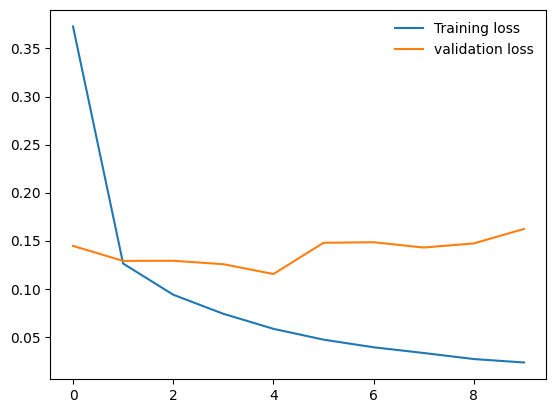

In [21]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [22]:
eval_model(model, test_dataloader, criterion)

  0%|          | 0/358 [00:00<?, ?it/s]

(0.15686100478022555,
 {'Accuracy': 0.9665975235004113,
  'precision': 0.016437869296725756,
  'recall': 0.021390992657686302,
  'f1': 0.0185901622870924})